# Parameters

In [32]:
# TRACEFILE = "./MsgTraces_W5_load-80p_0_IMPORTANT.tr"
TRACEFILE = "./MsgTraces_W5_load-1000p_0_10x_load.tr"

In [45]:
from typing import Dict, List
from collections import defaultdict

class Message:
    def __init__(self, sender, receiver, txid, sz):
        self.sender = sender
        self.receiver = receiver
        self.key = self.get_key(sender, receiver, txid)

        self.sz = sz
        self.start_ts = 0.0
        self.end_ts = 0.0
    
    @property
    def completion_time(self):
        return self.end_ts - self.start_ts
    
    @staticmethod
    def get_key(sender, receiver, txid):
        return "%s %s\t%s" % (sender, receiver, txid)
    
    def __str__(self):
        return f"{self.key}\t{self.completion_time}"

def process(tracefile):

    messages: Dict[str, List[Message]] = defaultdict(lambda: []) 
    messages_size2delays: Dict[int, List[float]] = defaultdict(lambda: []) 
    messages_allsizes: List[int] = []

    with open(tracefile, "r") as f:
        for line in f:
            log = line.split()
            ts = float(log[1]) * 1e-9   # seconds
            sz = int(log[2])            # bytes
            sender = log[3]             # ip:port
            receiver = log[4]             # ip:port
            txid = int(log[5])

            key = Message.get_key(sender, receiver, txid)

            if log[0] == "+":
                msg = Message(sender, receiver, txid, sz)
                msg.start_ts = ts
                messages[key].append(msg)
            elif log[0] == "-":
                msg = next((m for m in messages[key] if m.end_ts == 0), None)
                if not msg:
                    print("ERROR: cannot find start entry for ", line)
                    continue
                
                if msg.end_ts:
                    print("Message already has an end_ts!", msg)
                    continue
                
                msg.end_ts = ts
                messages_allsizes.append(msg.sz)
                messages_size2delays[msg.sz].append(msg.completion_time)

    all_messages_list = []
    for msgs in list(messages.values()):
        all_messages_list.extend(msgs)
    
    return all_messages_list

In [34]:
# for msg in all_messages_list:
#     print(msg)

In [35]:

import numpy as np
from scipy import stats

messages_allsizes = np.array(messages_allsizes)
msg_size_percentiles = stats.rankdata(messages_allsizes, "max")/len(messages_allsizes) * 100


In [36]:
# some basic statistics

print("Total number of messages:", len(all_messages_list))
print("Total number of distinct message sizes:", len(messages_size2delays))

num_incomplete = len([msg for msg in all_messages_list if msg.end_ts == 0])
print("Number of incomplete messages: %s" % num_incomplete)

# sorted_sizes = sorted(messages_size2delays.keys())
# for i, sz in enumerate(sorted_sizes):
#     if i == 0:
#         print(sz)
#     else:
#         print(f"{sz} +{sz - sorted_sizes[i - 1]}")


Total number of messages: 46850
Total number of distinct message sizes: 87
Number of incomplete messages: 1631


In [37]:
import matplotlib.pyplot as plt


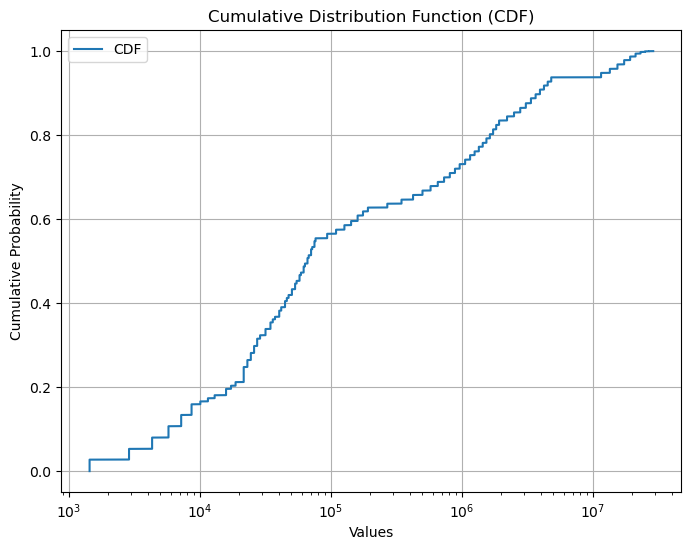

In [38]:
# basic CDF of message sizes

# Sorting the data
sorted_data = np.sort(messages_allsizes)

# Calculating the cumulative distribution
cdf = np.linspace(0, 1, len(sorted_data))

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, label='CDF')

plt.xscale("log")

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF)')

# Show legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Average receiver bandwith utilization

/tmp/ipykernel_377080/498874310.py:30: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


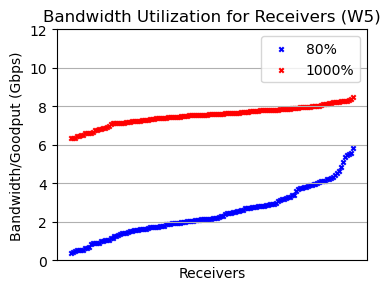

In [61]:
def chart(all_messages_list, color, label):
    rx_util = dict()

    recv_start_ts = defaultdict(lambda: 999999999999)
    recv_end_ts = defaultdict(lambda: 0)
    recv_bytes = defaultdict(int)

    for msg in all_messages_list:
        if not msg.end_ts:
            continue
        recv_start_ts[msg.receiver] = min(msg.start_ts, recv_start_ts[msg.receiver])
        recv_end_ts[msg.receiver] = max(msg.end_ts, recv_end_ts[msg.receiver])
        recv_bytes[msg.receiver] += msg.sz

    for r, totsz in recv_bytes.items():
        duration = recv_end_ts[r] - recv_start_ts[r]
        rx_util[r] = (totsz * 8 / duration) / 1024 / 1024 / 1024

    # Creating the scatter plot
    plt.scatter(rx_util.keys(), sorted(rx_util.values()), color=color, marker='x', label=label, s=10)

plt.figure(figsize=(4, 3))  # Set the figure size
chart(process("./MsgTraces_W5_load-80p_0_IMPORTANT.tr"), color="blue", label="80%")
chart(process("./MsgTraces_W5_load-1000p_0_10x_load.tr"), color="red", label="1000%")

# Adding labels and title
plt.title('Bandwidth Utilization for Receivers (W5)')
plt.xlabel('Receivers')
plt.ylabel('Bandwidth/Goodput (Gbps)')
plt.xticks([])
plt.ylim([0,10])
plt.legend()

# Show grid
# plt.grid(True)
plt.grid(axis='y', which='major')  # Show only horizontal grid lines on the y-axis

# Display the plot
plt.show()

# for msg in all_messages_list:
#     if msg.receiver in rx_util:
#         rx_util[msg.receiver] += msg.sz
#     else:
#         rx_util[msg.receiver] = msg.sz

# for k in rx_util.keys():
#     rx_util[k] /= max_bytes
#     if rx_util[k] > 1:
#         print("Hellfire!", rx_util[k])


